In [2]:
import lsst.daf.persistence as dafPersist
from lsst.ip.diffim import GetCoaddAsTemplateTask, GetCalexpAsTemplateTask
import lsst.afw.display.ds9 as ds9
import lsst.afw.geom as afwGeom
import lsst.meas.algorithms.detection as sDet
import lsst.afw.image as afwImage
import matplotlib.pyplot as plt
import numpy as np
import astropy.modeling.functional_models as f_models


In [3]:
def visualize_array(image_array):


    plt.figure(figsize=(30, 30))
    vmin = image_array.mean()-image_array.std()
    vmax = image_array.mean()+image_array.std()
    
    plt.imshow(image_array, vmin=vmin, vmax=vmax, cmap = 'Greys_r', origin='lower')
    plt.title('New Real Image', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    #plt.plot([coord_x], [coord_y], 'ro',  markersize =1.5)
    #plt.yticks(range(0,image_array.shape[0]+250, 250))
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
def insert_in_image(im1, im2, x, y):
    w, h = im2.shape
    std = im1.std()
    for i in range(w):
        for j in range(h):
            cx = x + (j - w/2)
            cy = y + (i - h/2)
            im1[cy, cx] = im2[i, j]*(std*100)
            #im1[cy, cx] = -100
            #print im1.std()*10
            
    return im1
    

In [4]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
DATA_ID={'visit': 850586 , 'filter':'r' , 'ccd':14}

In [5]:
calexp=butler.get('calexp', DATA_ID)

In [6]:
bgConf = sDet.BackgroundConfig()
background,calexp = sDet.estimateBackground(calexp,bgConf,True)

In [7]:
ds9.mtv(background.getImageF(), frame=3)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [8]:
image_calexp = calexp.getMaskedImage().getImage()
calexp_array = image_calexp.getArray()

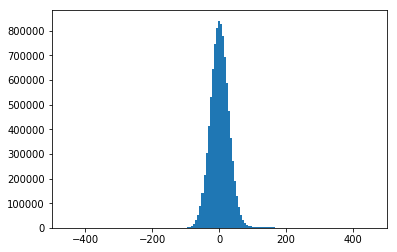

In [10]:
%matplotlib inline
n, bins, patches = plt.hist(calexp_array.ravel(), bins = 10000)
plt.xlim(xmin=-500, xmax=500)
plt.show()

sigma value 26.9129804269
mean value 0.335934667919


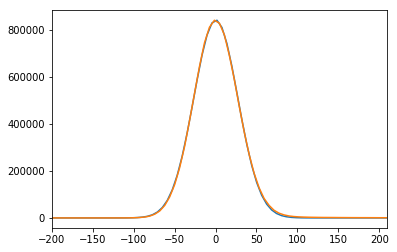

In [11]:
bcenters = 0.5*(bins[1:]+bins[:-1])
mu = np.mean(calexp_array.ravel())
from scipy.optimize import curve_fit

def gaussian(x, am, mu, sigma):
    return am*np.exp(-(x-mu)**2/(2*sigma**2))


init_vals = [1, 0,1.0]
best_val, covar = curve_fit(gaussian, bcenters, n, p0=init_vals)
x = np.linspace(min(calexp_array.ravel()),max(calexp_array.ravel()), 10000)
plt.plot(x, gaussian(x, best_val[0], best_val[1], best_val[2]))
plt.xlim(xmin=-200, xmax=209)

plt.plot(bcenters, n)
print("sigma value "+str(best_val[-1]))

print("mean value "+str(best_val[1]))
sigma = best_val[-1]
plt.show()


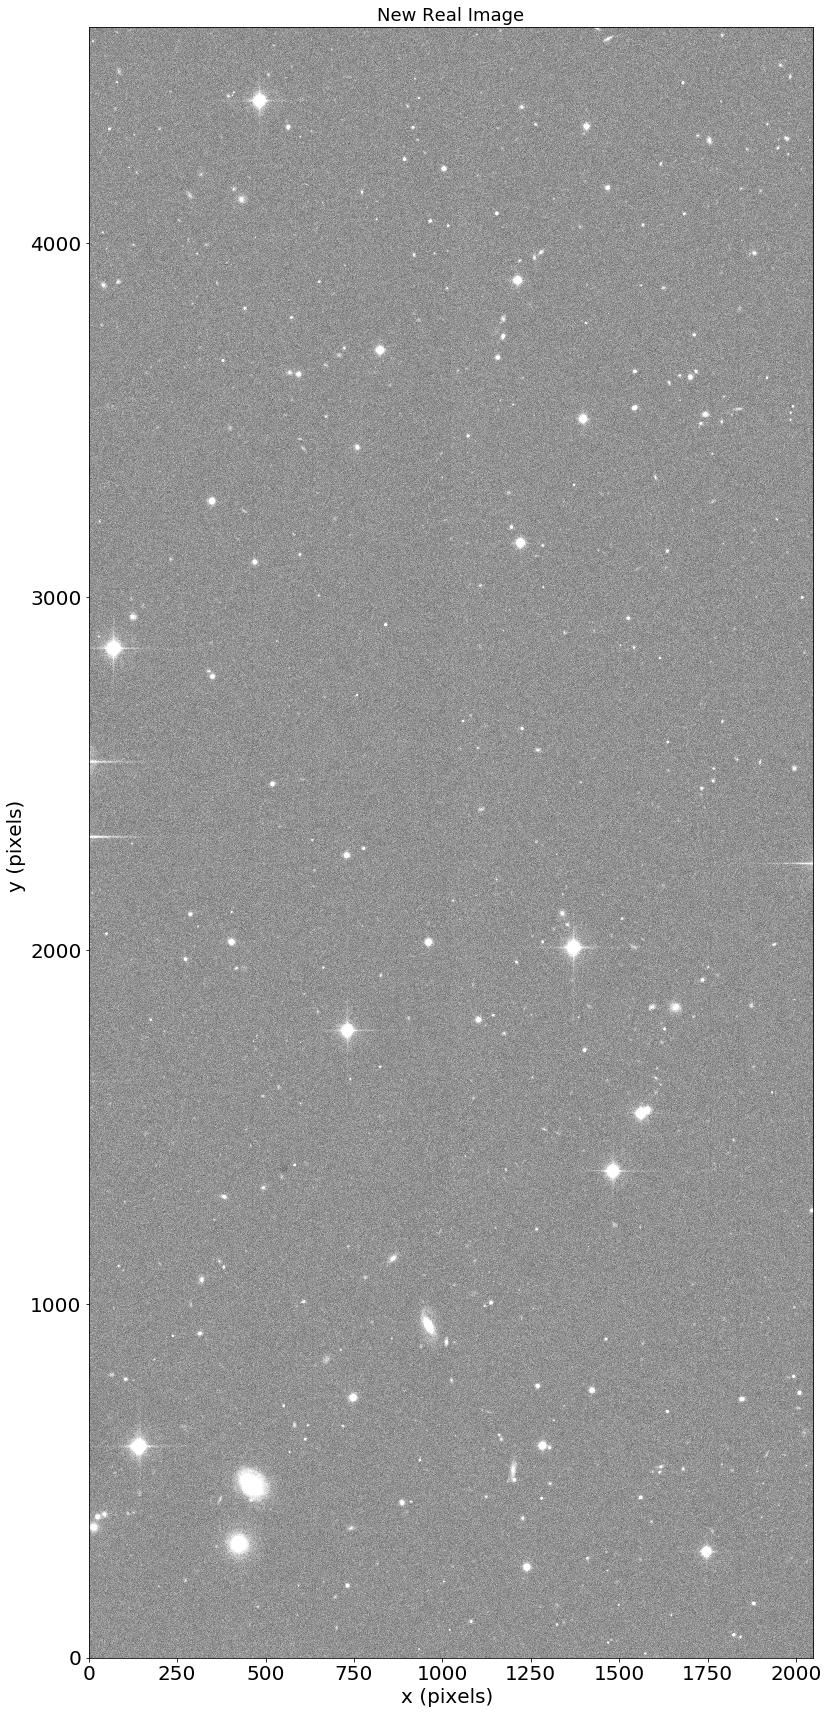

In [12]:
%matplotlib inline
image_array = calexp_array
fig = plt.figure(figsize = (30,30))
plt.imshow(image_array, vmin= image_array.mean()-image_array.std(), vmax=image_array.mean()+image_array.std(), cmap = 'Greys_r', origin='lower')
plt.title('New Real Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [42]:
import random
def generate_coordinates(number, w, h, distance):
    coordinates = []
    i=0
    while i < number:
        coord_x, coord_y = random.random()*w, random.random()*h
        if is_far_from((coord_x, coord_y),coordinates, distance) == True:
            coordinates.append((coord_x, coord_y))
            i+=1
        
    return coordinates

def is_far_from( point, coordinates, distance):
    
    for point2 in coordinates:
        if squared_euclidean_distance(point, point2) < distance**2:
            return False
    return True
    
    
def squared_euclidean_distance(point1, point2):
    
    return (point2[0]-point1[0])**2 + (point2[1]-point1[1])**2
        
        

In [43]:
w, h = calexp.getDimensions()
supernovae = generate_coordinates(1000,w, h, 20)

In [62]:
import random
factor = 20

calexp_copy = calexp.clone()
calexp_array = calexp_copy.getMaskedImage().getImage().getArray()
psf = calexp.getPsf()
for coord_x, coord_y in supernovae:
   
    qpole = psf.computeShape(afwGeom.Point2D(coord_x, coord_y))
    cov = [[qpole.getIxx(), qpole.getIxy()],[qpole.getIxy(), qpole.getIyy()]]
    g2 = f_models.Gaussian2D(amplitude=sigma*factor, x_mean=coord_x, y_mean=coord_y, cov_matrix = cov)
    #g2.bounding_box=False
    psf_added = g2.render(calexp_array)
    


    

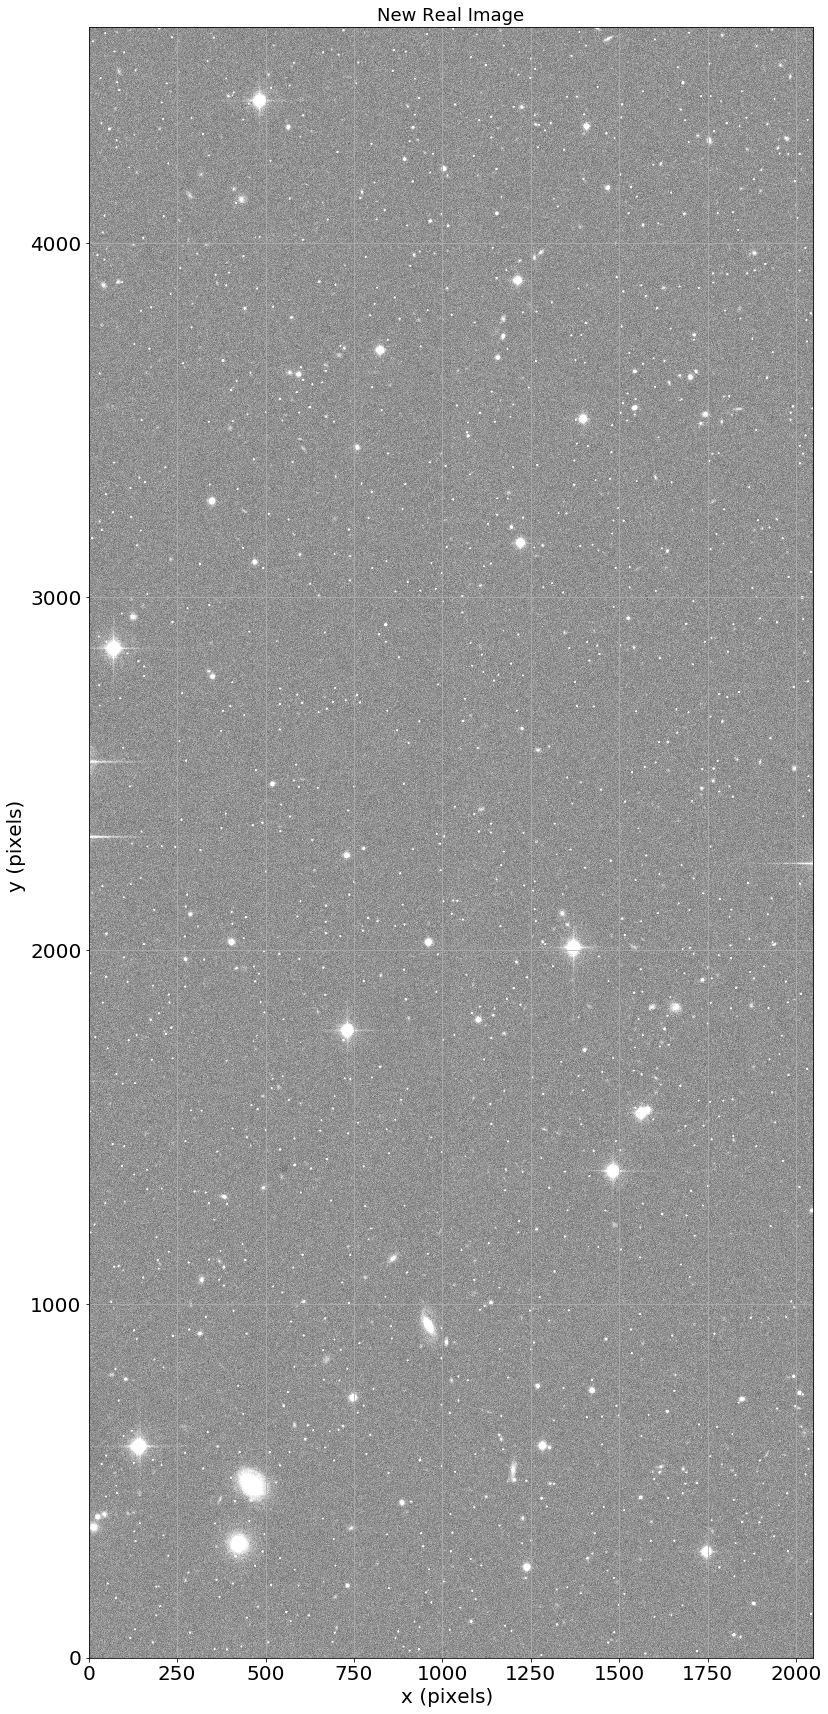

In [63]:
visualize_array(psf_added)


In [64]:
calexp_copy.writeFits("/renoir_data_02/jpreyes/lsst_data/calexp_copy_"+str(factor)+".fits")

In [66]:
import pickle

out = open("/renoir_data_02/jpreyes/lsst_data/calexp_coords.pickle", "wb")


pickle.dump(supernovae, out)
out.close()

In [ ]:
result = insert_in_image(calexp_array.copy(), psf_shape, coord_x, coord_y)
result

In [ ]:
image_array = result
plt.figure(figsize=(30, 30))
vmin = calexp_array.mean()-calexp_array.std()
vmax=calexp_array.mean()+calexp_array.std()
plt.imshow(image_array, vmin=vmin, vmax=vmax, cmap = 'Greys_r', origin='lower')
plt.title('New Real Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
#plt.plot([coord_x], [coord_y], 'ro',  markersize =1.5)
plt.yticks(range(0,image_array.shape[0]+250, 250))
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=20)